# Sanity check: income dataset with linear models

In [1]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from flow import edge_credits2edge_credit
from on_manifold import OnManifoldExplainer, IndExplainer, FeatureAttribution
from linear_evaluation import get_error, get_indirect_effect_flow, get_effect_asv, get_effect_ind, get_effect_manifold, get_direct_effect_flow
from linear_evaluation import get_direct_effect_ground_truth, get_indirect_effect_ground_truth

np.random.seed(42)

# Dataset and Training

In [2]:
X, y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True) # human readable feature values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=10000).fit(X_train, y_train)

# Explanation setting

In [3]:
nsamples = 100 # paper: 1000 samples
bg = X.fillna(X.mean()).sample(1) # background sample, no need for multiple sample because of the linearity axiom
fg = X[:nsamples] # foreground samples to explain

# Build a causal graph

learning dependency for Marital Status: 100%|██████████| 8/8 [00:00<00:00, 85.40it/s]


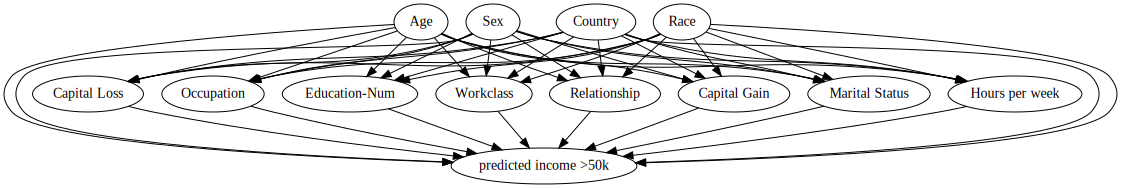

In [4]:
causal_links = CausalLinks()
categorical_feature_names = [] # a linear model doesn't handle categorical features
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted income >50k' # 'predicted hazard'
feature_names = list(X.columns)
f = lambda x: x.dot(model.coef_.reshape(-1, 1)).ravel() + model.intercept_ # logit is linear log(p / 1-p)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_linear_f(feature_names, f))
A = ['Age', 'Sex', 'Country', 'Race']
D = list(set(feature_names) - set(A))
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name, method='linear')

causal_graph.draw()

# Explain

Flow, ASV, and SHAP converge in 1 run b/c the model is linear.

In [5]:
cf_flow_adult = GraphExplainer(causal_graph, bg, nruns=1).shap_values(fg)

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 58.57it/s]


In [6]:
bg_on_manifold = X.fillna(X.mean()).sample(100) # used to learn conditional dependence
explainer = OnManifoldExplainer(f, pd.concat([bg, bg_on_manifold]), nruns=100, sigma_sq=0.1)  # need > 1 run b/c conditional expectation is non-linear
cf_on_manifold_adult = explainer.shap_values(fg)

manifold bg samples: 100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


In [7]:
explainer = IndExplainer(f, bg, nruns=1)
cf_ind_adult = explainer.shap_values(fg)

100%|██████████| 1/1 [00:00<00:00, 1088.58it/s]


# Compare baselines

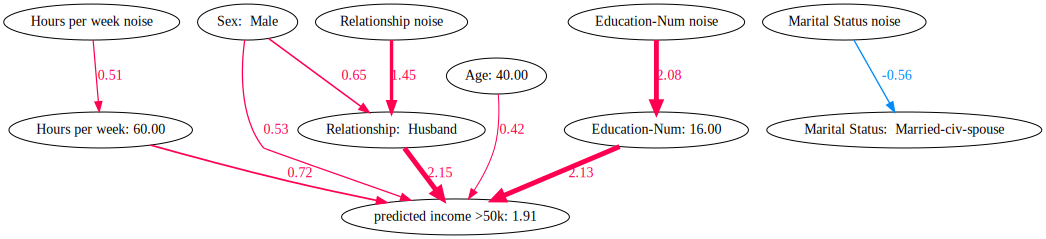

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f7360436480>>

In [8]:
sample_ind = 20
cf_flow_adult.fold_noise=False
cf_flow_adult.draw(sample_ind, max_display=10)

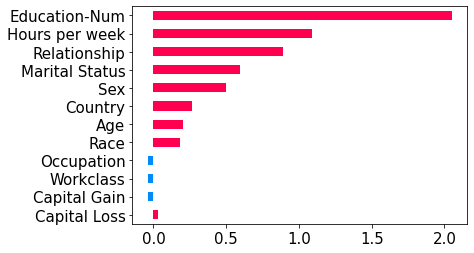

In [9]:
cf_on_manifold_adult.draw(sample_ind)

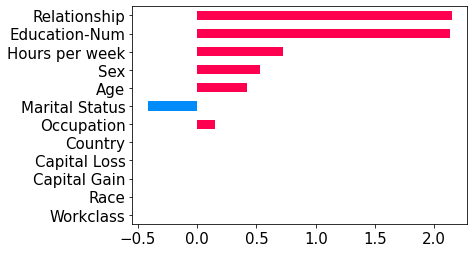

In [10]:
cf_ind_adult.draw(sample_ind)

ASV


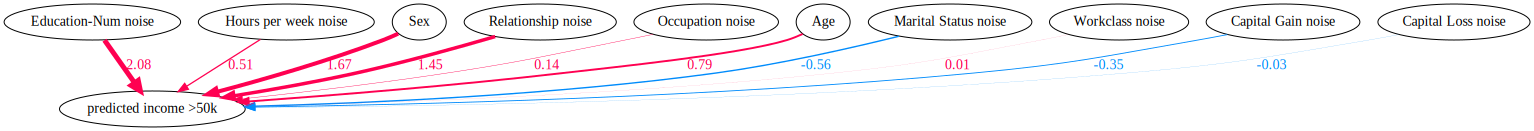

In [11]:
# asv
print('ASV')
cf_flow_adult.fold_noise = False
g = cf_flow_adult.draw_asv(sample_ind, max_display=10, show_fg_val=False)

# Calculate difference with the ground truth

In [12]:
gt = get_direct_effect_ground_truth(cf_flow_adult.graph)
theta_ind = get_effect_ind(cf_ind_adult)
theta_manifold = get_effect_manifold(cf_on_manifold_adult)
theta_asv = get_effect_asv(cf_flow_adult)
theta_flow = get_direct_effect_flow(cf_flow_adult)

gt_indirect = get_indirect_effect_ground_truth(cf_flow_adult.graph)
theta_flow_indirect = get_indirect_effect_flow(cf_flow_adult)

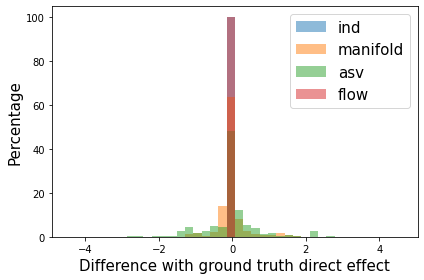

       ind: 0.0 ($\pm$ 0.0)
  manifold: 0.2 ($\pm$ 0.3)
       asv: 0.4 ($\pm$ 0.6)
      flow: 0.0 ($\pm$ 0.0)


In [13]:
errors = {
    'ind': get_error(gt, theta_ind),
    'manifold': get_error(gt, theta_manifold),
    'asv': get_error(gt, theta_asv),
    'flow': get_error(gt, theta_flow)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] # get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth direct effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

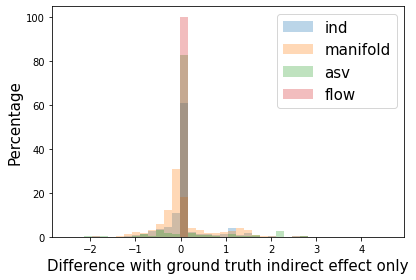

       ind: 0.2 ($\pm$ 0.5)
  manifold: 0.4 ($\pm$ 0.5)
       asv: 0.2 ($\pm$ 0.5)
      flow: 0.0 ($\pm$ 0.0)


In [14]:
errors = {
    'ind': get_error(gt_indirect, theta_ind),
    'manifold': get_error(gt_indirect, theta_manifold),
    'asv': get_error(gt_indirect, theta_asv),
    'flow': get_error(gt_indirect, theta_flow_indirect)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.3, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth indirect effect only', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.show()

for k, v in errors.items():
    print(f"{k:>10s}: {np.abs(v).mean().round(1)} ($\pm$ {np.abs(v).std().round(1)})")

Only Shapley Flow makes no mistake on both the direct and indirect effects.